# Imports

In [10]:
import sys
import os
import shutil
import gc
import numpy as np
import scipy.integrate as it
import subprocess as sub
import matplotlib.pyplot as plt
import linecache as l
import pandas as pd
from scipy import signal
from scipy.optimize import curve_fit
from scipy import fftpack
import re, csv, math
import itertools

# Matplotlib Settings

import matplotlib
from matplotlib import rc

# Setting font size
fontsize = 30
rc('font', **{'family':'serif', 'serif':['Times'], 'size': fontsize})
rc('pdf', fonttype=42)
rc('text', usetex=True)
params = {'axes.labelsize': fontsize,'axes.titlesize':fontsize, 'legend.fontsize': fontsize, 'xtick.labelsize': fontsize, 'ytick.labelsize': fontsize}
matplotlib.rcParams.update(params)
pot = 1
markers = ['o', '^', 's', 'v','>','<','1','2','3','8']
colors = ['k', 'r', 'steelblue','mediumseagreen','b','g','c','m','y','w']

# Data reading and splitting

In [11]:
def avedata(file_name):
    VAL = np.loadtxt(file_name, dtype = int,skiprows=3,max_rows=1)
    maxrows = VAL[1]
    a = 4
    bindat = np.loadtxt(file_name, dtype = float,skiprows=a,max_rows=int(maxrows))[:,[0,1,2]]
    sum_dat =[]
    for i in range(5):
        VAL1 = np.loadtxt(file_name, dtype = float,skiprows=a,max_rows=int(maxrows))[:,3].reshape(maxrows,1)
        sum_dat.append(VAL1)
        a += maxrows+1
    ave_dat = np.sum(sum_dat,axis=0)/5
    bindat=np.append(bindat, ave_dat, axis=1)
    return bindat

In [12]:
pot = 1
prodrun=5000000
dt=1.0
A=1890
kb=1.987204e-3  #real units
kCal2Joule=4184
avaga=6.02214179e23
fs2s=1.0e-15
A2m =1.0e-10
K_real2SI=A2m*A2m*avaga*fs2s/(kCal2Joule)  #kapitza
K_real2SIcond=kCal2Joule/(avaga*fs2s*A2m)  #conductivity

In [13]:
def SmoothGrad(x_left, T_graL, x_mid, Tw, x_right, T_graR,x_leftfull,x_midfull,x_rightfull):
    
    pL=np.poly1d(np.polyfit(x_left,T_graL,1))
    pmid=np.poly1d(np.polyfit(x_mid,Tw,1))
    pR=np.poly1d(np.polyfit(x_right,T_graR,1))

    #x=np.concatenate([x_left,x_mid,x_right],axis=0)
    #p=np.concatenate([pL(x_left),pmid(x_mid),pR(x_right)],axis=0)
    L=np.column_stack((x_left,pL(x_left)))
    Lfull=np.column_stack((x_leftfull,pL(x_leftfull)))
    M=np.column_stack((x_mid,pmid(x_mid)))
    Mfull=np.column_stack((x_midfull,pmid(x_midfull)))
    R=np.column_stack((x_right,pR(x_right)))
    Rfull=np.column_stack((x_rightfull,pR(x_rightfull)))
    return L,M,R,Lfull,Mfull,Rfull

In [14]:
def cutXT2(x_left, T_graL, x_mid, Tw, x_right, T_graR):
    n=np.size(x_left)
    #print(x_left)
    x_left=np.delete(x_left, [0,1,2], axis=0)
    x_left=x_left[0:6]
    n=np.size(x_right)
    x_right=np.delete(x_right, [0,n-1,n-2,n-3], axis=0)
    x_right=x_right[0:6]
    n=np.size(x_mid)
    x_mid=np.delete(x_mid,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,n-51,n-50,n-49,n-48,n-47,n-46,n-45,n-44,n-43,n-42,n-41,n-40,n-39,n-38,n-37,n-36,n-35,n-34,n-33,n-32,n-31,n-30,n-29,n-28,n-27,n-26,n-25,n-24,n-23,n-22,n-21,n-20,n-19,n-18,n-17,n-16,n-15,n-14,n-13,n-12,n-11,n-10,n-9,n-8,n-7,n-6,n-5,n-4,n-3,n-2,n-1])
    n=np.size(T_graL)
    T_graL=np.delete(T_graL, [0,1,2], axis=0)
    T_graL=T_graL[0:6]
    n=np.size(T_graR)
    T_graR=np.delete(T_graR, [0,n-1,n-2,n-3], axis=0)
    T_graR=T_graR[0:6]    
    n=np.size(Tw)
    Tw=np.delete(Tw,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,n-51,n-50,n-49,n-48,n-47,n-46,n-45,n-44,n-43,n-42,n-41,n-40,n-39,n-38,n-37,n-36,n-35,n-34,n-33,n-32,n-31,n-30,n-29,n-28,n-27,n-26,n-25,n-24,n-23,n-22,n-21,n-20,n-19,n-18,n-17,n-16,n-15,n-14,n-13,n-12,n-11,n-10,n-9,n-8,n-7,n-6,n-5,n-4,n-3,n-2,n-1])
    #print(x_left, T_graL, x_mid, Tw, x_right, T_graR)
    return x_left, T_graL, x_mid, Tw, x_right, T_graR

In [15]:
def calcThermal(x_left, T_graL, x_mid, Tw, x_right, T_graR,Q_flux):
    slope_TgraL, c_TgraL=np.polyfit(x_left,T_graL,1)
    slope_Tw, c_Tw=np.polyfit(x_mid,Tw,1)
    slope_TgraR, c_TgraR=np.polyfit(x_right,T_graR,1)
    
    k_graL=-(Q_flux/(slope_TgraL))    #W/mK
    k_W=-(Q_flux/(slope_Tw))
    k_graR=-(Q_flux/(slope_TgraR))

    x_intL=-wall
    x_intLw=-wall
    x_intR=wall
    x_intRw=wall

    Tint_lGra=slope_TgraL*x_intL+c_TgraL
    Tint_lWat=slope_Tw*x_intLw+c_Tw
    Tint_rWat=slope_Tw*x_intRw+c_Tw
    Tint_rGra=slope_TgraR*x_intR+c_TgraR
    delTL= Tint_lGra-Tint_lWat
    delTR=Tint_rWat-Tint_rGra
    G_L=((Tint_lGra-Tint_lWat))/Q_flux    #m2K/W
    G_R=((Tint_rWat-Tint_rGra))/Q_flux
    print("Temperature drop left  =",delTL,'K')
    print("Temperature drop right  =",delTR,'K')
    return k_graL,k_W,k_graR,G_L,G_R 

In [19]:
diranl="/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/tswap/NEMD"
conrange= [100,200,300,400]
trange= [350]
crange=[0.1,0.2,0.3,0.4,0.5,0.6]
iruns = [2]
kap=[]
denpeakL=[]
denpeakR=[]
denpeakLz=[]
denpeakRz=[]
Qnet=[]
cf=[]
bulkden=[]
kleft=[]
kright=[]
lk=[]
lkleft=[]
lkright=[]
KvsC=[]
KvsM=[]
    #print(Tfluid,Q)
for con in conrange:
    for c in crange:
        Q=[]
        Tfluid=[]
        Tleft=[]
        Tright=[]
        den =[]
        for irun in iruns:
            T=350
            print(con,T,c)
            heat=np.loadtxt(diranl+'/bf_'+str(con)+'/'+str(c)+'/heatflux.'+str(irun)+"."+str(T)+".dat")
            #heat=np.loadtxt(diranl+str(c)+'/bf_'+str(con)+'/heatfluxfull.'+str(irun)+"."+str(T)+".dat")
           # print(heat[4999][0],heat[3999][0])
            #print(heat[4999][1],heat[3999][1])
            #Heat1=np.absolute(heat[4999][0]-heat[3999][0])
            #Heat2=np.absolute(heat[4999][1]-heat[3999][1])
            Heat1=np.absolute(heat[0])
            Heat2=np.absolute(heat[1])          
            print(Heat1,Heat2)
            Q_fluxreal=-((Heat1+Heat2)*0.5)/(prodrun*dt*A)
            Q_flux=Q_fluxreal
            print(Q_flux)
            Q.append(Q_flux)
            
            datafluid=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/temp_fluid.'+str(irun)+"."+str(T)+".profile")
#datafluid=np.loadtxt(diranl+'tmp_water.profile',skiprows=4)
            tempfluid=datafluid[:,3]
            Tfluid.append(tempfluid)
           # print(Tfluid)
            dataleft=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/temp_gnc_left.'+str(irun)+"."+str(T)+".profile")
#dataleft=np.loadtxt(diranl+'tmp_gnc_left.profile',skiprows=4)
            templeft=dataleft[:,3]
            Tleft.append(templeft)
            dataright=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/temp_gnc_right.'+str(irun)+"."+str(T)+".profile")
#dataright=np.loadtxt(diranl+'tmp_gnc_right.profile',skiprows=4)
            tempright=dataright[:,3]
            wall = dataright[:,1][0]
            Tright.append(tempright)
        
            denfluid=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/dens_fluid.'+str(irun)+"."+str(T)+".profile")
#datafluid=np.loadtxt(diranl+'tmp_water.profile',skiprows=4)
            density=denfluid[:,3]
            den.append(density)   
#print(Tfluid)
        Qmean= sum(Q)/len(Q)
        print(Qmean)
        tmeanfluid= np.mean(Tfluid, axis = 0)
        tmeanleft=np.mean(Tleft, axis = 0)
        tmeanright=np.mean(Tright, axis = 0)
        denavg = np.mean(den, axis = 0)
    #print(tmeanfluid,tmeanleft,tmeanright)

        zfluid=datafluid[:,1]
        zleft=dataleft[:,1]
        zright=dataright[:,1]
        zden = denfluid[:,1]
        zcord=np.concatenate([zleft,zfluid,zright],axis=0)
        temp=np.concatenate([templeft,tempfluid,tempright],axis=0)
        result="/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/tswap/NEMD/NEMD_RESULTS/"
        directory = result
        parent_dir = "bf="+str(con)+'/c='+str(c)
        path = os.path.join(directory , parent_dir)
        print(path)
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)
        np.savetxt(path+'/tempGrad.'+"."+str(T)+".dat", np.column_stack((zcord,temp)))
        np.savetxt(path+'/tempGradleft.'+"."+str(T)+".dat", np.column_stack((zleft,templeft)))
        np.savetxt(path+'/tempGradfluid.'+"."+str(T)+".dat", np.column_stack((zfluid,tempfluid)))
        np.savetxt(path+'/tempGradright.'+"."+str(T)+".dat", np.column_stack((zright,tempright)))
        np.savetxt(path+'/dengrad.'+"."+str(T)+".dat", np.column_stack((zden,denavg)))    

###  Trimming edges
        zleft_trim,templeft,zfluid_trim,tempfluid,zright_trim,tempright=cutXT2(zleft,templeft,zfluid,tempfluid,zright,tempright)
        print(templeft,tempright)
###  Smoothening data
        zcord_trim=np.concatenate([zleft_trim,zfluid_trim,zright_trim],axis=0)
        temp_trim=np.concatenate([templeft,tempfluid,tempright],axis=0)
#zmidfull=np.linspace(fluid[0],fluid[1],num=fluid[2])
        left,mid,right,leftfull,midfull,rightfull=SmoothGrad(zleft_trim,templeft,zfluid_trim,tempfluid,zright_trim,tempright,zleft,zfluid,zright)
        np.savetxt(path+'/smoothGradleft.'+str(T)+"."+".dat", leftfull)
        np.savetxt(path+'/smoothGradright.'+str(T)+"."+".dat", rightfull)
        np.savetxt(path+'/smoothGradfluid.'+str(T)+"."+".dat", midfull)

###  Kapitza and conductivity
        C_left,C_fluid,C_right,K_left,K_right=calcThermal(zleft_trim,templeft,zfluid_trim,tempfluid,zright_trim,tempright,Q_flux)
        C_left=C_left*K_real2SIcond
        C_right=C_right*K_real2SIcond
        C_fluid=C_fluid*K_real2SIcond
        K_left=K_left*K_real2SI
        K_right=K_right*K_real2SI
        C_solid=0.5*(C_left+C_right)
        K=0.5*1000000000*(K_left+K_right)
        l_kleft = C_fluid *K_left*1000000000
        l_kright = C_fluid * K_right*1000000000
        l_k = 0.5*(l_kleft+l_kright)
        np.savetxt(path+'/thermalCond.'+"."+str(T)+".dat",np.vstack((C_left,C_fluid,C_right,C_fluid,C_solid)))  
        np.savetxt(path+'/boundaryCond.'+"."+str(T)+".dat", np.vstack((K_left,K_right,K))) 
        print("##########",T,pot,"#########################")
        #print("Conductivity left  =",C_left,'W/mK')
        #print("Conductivity right =",C_right,'W/mK')
        #print("Conductivity Fluid =",C_fluid,'W/mK')
        #print("Conductivity Solid =",C_solid,'W/mK')
        print("Kapitza left       =",K_left,'m2K/W')
        print("Kapitza length left       =",l_kleft,'nm')
        print("Kapitza right      =",K_right,'m2K/W')
        print("Kapitza length right      =",l_kright,'nm')
        print("heatflux    =",Qmean,'W/m^2')
        #print("Kapitza Average    =",K,'m2K/GW')
        #print("Kapitza length Average    =",l_k,'nm')
        kap.append(K)
        kleft.append(K_left)
        kright.append(K_right)
        lk.append(l_k)
        lkleft.append(l_kleft)
        lkright.append(l_kright)
        KvsC.append((con,c,K_left,K_right))
        KvsM.append((c,con,K_left,K_right))
        print("###################################")
        data = pd.read_csv(path+'/dengrad.'+"."+str(T)+".dat",sep='\s+',header=None)
        data = pd.DataFrame(data)
        x = data[0]
        y = data[1]
        bins= int(np.size(y)/5)
        dmaxL=max(y[:bins])
        dmaxR=max(y[-bins:])
        yleft=y[:bins]
        yright=y[-bins:]
        dmaxLz=x[yleft.argmax()]
        dmaxRz=x[bins-int(yright.argmax())]        
        print(dmaxL,dmaxLz,dmaxR,dmaxRz)
        Qnet.append(Qmean)
        denpeakL.append(dmaxL)
        denpeakR.append(dmaxR)
        denpeakLz.append(dmaxLz)
        denpeakRz.append(dmaxRz)
        cf.append(C_fluid)
        z=y[bins:]
        zz=z[:-bins]
        zzz=np.mean(zz)
        bulkden.append(zzz)
     #   plt_1 = plt.figure(figsize=(10, 10))
        figure, axis = plt.subplots(1, 2)
        figure.set_size_inches(15, 5)
        axis[0].scatter(zleft_trim, templeft,color='b',label = 'Cold side')
        axis[0].scatter(zfluid_trim, tempfluid,color='brown',label = 'Fluid')
        axis[0].scatter(zright_trim, tempright,color='r',label = 'Hot side')
        #axis[0].set_title("Temperature profile@"+str(T))
        axis[1].plot(x, y,'b')
        #axis[1].set_title("Density Gradient_"+str(dmaxL))
        axis[0].legend(loc = 'lower right', shadow = True, 
            handlelength = 1.2, fontsize = 'large', borderaxespad = 0.7,ncol=1,frameon=True)
        axis[0].set_xlabel("z $(A^0)$",fontweight = 'bold',fontsize=12)
        axis[1].set_xlabel("z $(A^0)$",fontweight = 'bold',fontsize=12)
        axis[1].set_ylim(0,4)
        axis[0].set_ylabel("Temperature $(k)$",fontweight = 'bold',fontsize=12)
        axis[1].set_ylabel("Mass density $(kg/m^3)$",fontweight = 'bold',fontsize=12)
        extent = axis[0].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        plt.savefig(diranl+'/bf_'+str(con)+'/'+str(c)+'temp_pr'+str(c)+'.'+str(con)+'_tswap.png',dpi=600, bbox_inches=extent.expanded(1.25, 1.3))
        extent = axis[1].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        plt.savefig(diranl+'/bf_'+str(con)+'/'+str(c)+'dens_pro'+str(c)+'.'+str(con)+'_tswap.png',dpi=600, bbox_inches=extent.expanded(1.25, 1.3))        
        plt.savefig(diranl+'/bf_'+str(con)+'/'+str(c)+"fig"+str(c)+'.'+str(con)+'_tswap.png')
        #plt.show()
        plt.close()
#print(kap,kleft,kright,denpeakL,denpeakLz,denpeakR,denpeakRz,bulkden,Qnet)
np.savetxt('data_normal'+".dat", np.column_stack((kap,kleft,kright,denpeakL,denpeakLz,denpeakR,denpeakRz,bulkden,Qnet)),header='Kapitza k_left k_right peak_denL peak_denLz peak_denR peak_denRz bulk_den Qtotal')
np.savetxt('K_vs_charge_tswap.dat',KvsC,header='BF Charge k_left k_right')
np.savetxt('K_vs_molarity_tswap.dat',KvsM,header='Charge BF k_left k_right')

100 350 0.1
17097.5451816787 19479.9909993567
-1.9353193746579575e-06
-1.9353193746579575e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/tswap/NEMD/NEMD_RESULTS/bf=100/c=0.1
[392.8368 391.1654 392.6988 391.0408 390.7092 389.7754] [306.2696 306.0006 304.677  304.0368 304.173  304.0148]
Temperature drop left  = 10.934354176346005 K
Temperature drop right  = 1.663720770145062 K
########## 350 1 #########################
Kapitza left       = -8.132045379723025e-09 m2K/W
Kapitza length left       = 1.3617815430390023 nm
Kapitza right      = -1.2373344217507869e-09 m2K/W
Kapitza length right      = 0.20720238260210594 nm
heatflux    = -1.9353193746579575e-06 W/m^2
###################################
2.825382 -38.85 3.481584 -39.85
100 350 0.2
19351.8538031128 21574.7716501278
-2.1654299181608786e-06
-2.1654299181608786e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emi

## 1. TBR vs Surface Charge of Carbon atoms

     0    1             2             3
0  0.0  0.0  7.237763e-09  7.023402e-09
1  0.0  0.1  7.187424e-09  4.122788e-09
2  0.0  0.2  1.194812e-09  2.639524e-09
3  0.0  0.3  1.276769e-08  7.836826e-09
4  0.0  0.4  1.474430e-08  6.003415e-09
5  0.0  0.5  1.474430e-08  6.003415e-09
6  0.0  0.6  1.233182e-08  7.249024e-09


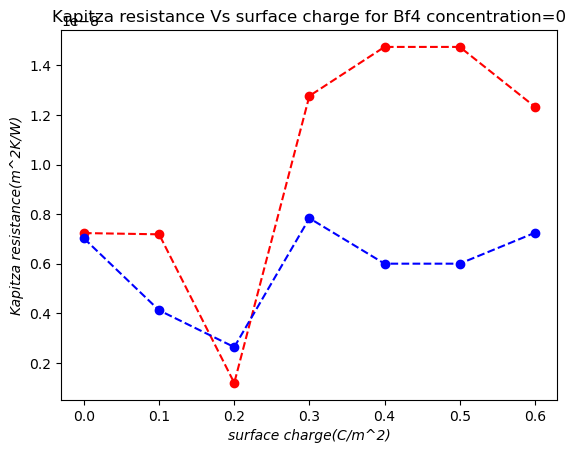

        0    1             2             3
7   100.0  0.0  5.909534e-09  8.637072e-09
8   100.0  0.1  6.760912e-09  4.797180e-09
9   100.0  0.2  3.153532e-09  1.559727e-09
10  100.0  0.3  5.347015e-09  7.461872e-09
11  100.0  0.4  1.105950e-08  9.359948e-09
12  100.0  0.5  1.613744e-08  9.052297e-09
13  100.0  0.6  1.317386e-08  9.214531e-09


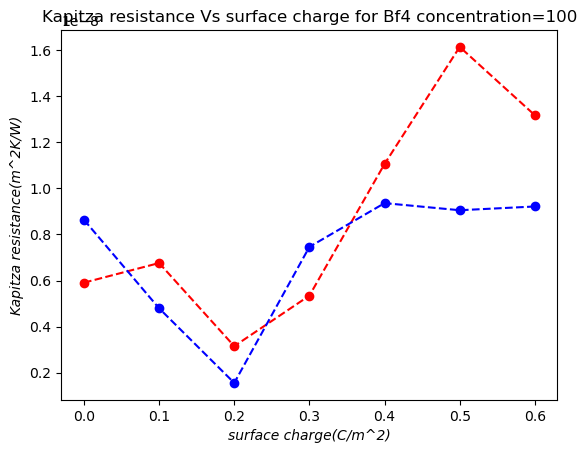

        0    1             2             3
14  200.0  0.0  7.363077e-09  9.732518e-09
15  200.0  0.1  7.703600e-09  5.070059e-09
16  200.0  0.2  3.449990e-09  2.626247e-09
17  200.0  0.3  5.317781e-09  5.880503e-09
18  200.0  0.4  7.940923e-09  9.060275e-09
19  200.0  0.5  1.428153e-08  1.116739e-08
20  200.0  0.6  1.173513e-08  9.764584e-09


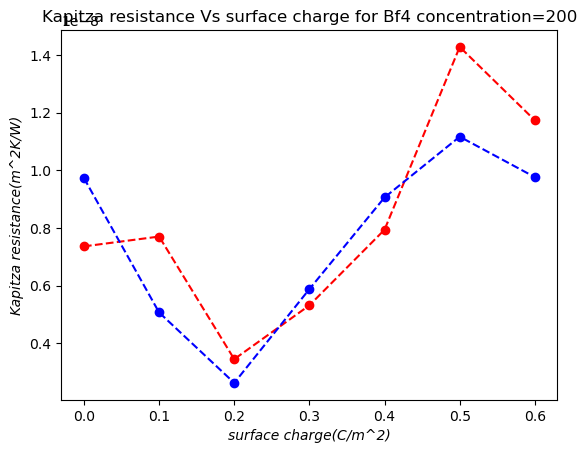

        0    1             2             3
21  300.0  0.0  8.502772e-09  8.840576e-09
22  300.0  0.1  5.968823e-09  3.452183e-09
23  300.0  0.2  4.407555e-09  3.160579e-09
24  300.0  0.3  6.959317e-09  6.840890e-09
25  300.0  0.4  9.365133e-09  1.116144e-08
26  300.0  0.5  1.222029e-08  1.060756e-08
27  300.0  0.6  1.284714e-08  5.505610e-09


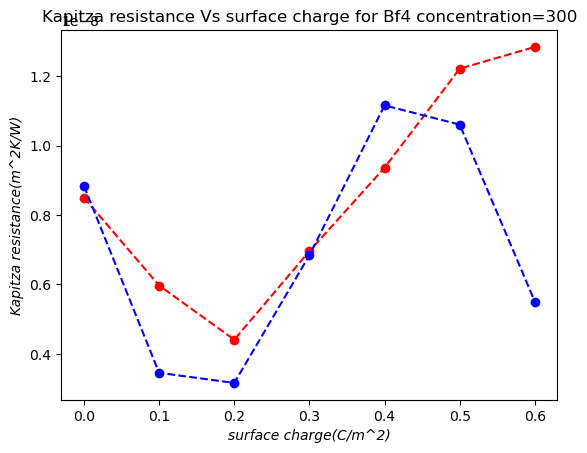

        0    1             2             3
28  400.0  0.0  6.154646e-09  7.471240e-09
29  400.0  0.1  6.225694e-09  3.945189e-09
30  400.0  0.2  3.441716e-09  2.132120e-09
31  400.0  0.3  5.595098e-09  4.923655e-09
32  400.0  0.4  1.091375e-08  1.096722e-08
33  400.0  0.5  1.488026e-08  1.101836e-08
34  400.0  0.6  1.677397e-08  1.226097e-08


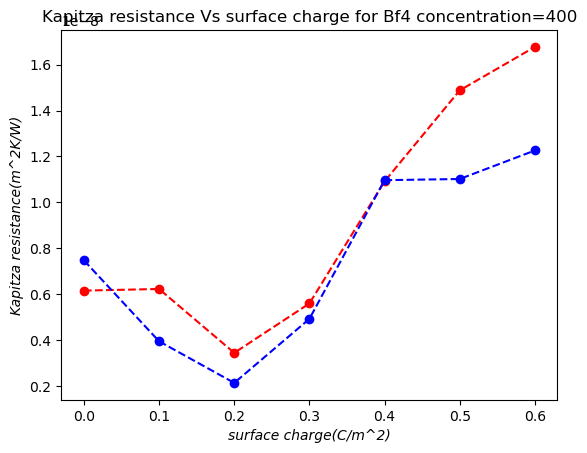

In [17]:
fig, ax = plt.subplots()
conrange= [0,100,200,300,400]
for con in conrange:
    data = pd.read_csv("K_vs_charge.dat",sep='\s+',skiprows=[0],header=None)
    data = pd.DataFrame(data)
    select_con = data.loc[data.iloc[:,0] == con]
    print(select_con)
    x = select_con[1]
    y1 = select_con[2]
    y2 = select_con[3]    
    plt.title('Kapitza resistance Vs surface charge for Bf4 concentration='+str(con))
    plt.plot(x, y1,color="red", marker="o",  linestyle="--",label='kapitza_left')
    plt.plot(x, y2,color="blue", marker="o",  linestyle="--",label='kapitza_right')
    plt.xlabel('surface charge(C/m^2)', style='italic')
    plt.ylabel('Kapitza resistance(m^2K/W)', style='italic')
    plt.savefig("K_vs_charge"+'.bf4='+str(con)+'.png')
    plt.show()

## 2. TBR vs Mixture Ratio

      0      1             2             3
0   0.0    0.0  7.237763e-09  7.023402e-09
7   0.0  100.0  5.909534e-09  8.637072e-09
14  0.0  200.0  7.363077e-09  9.732518e-09
21  0.0  300.0  8.502772e-09  8.840576e-09
28  0.0  400.0  6.154646e-09  7.471240e-09


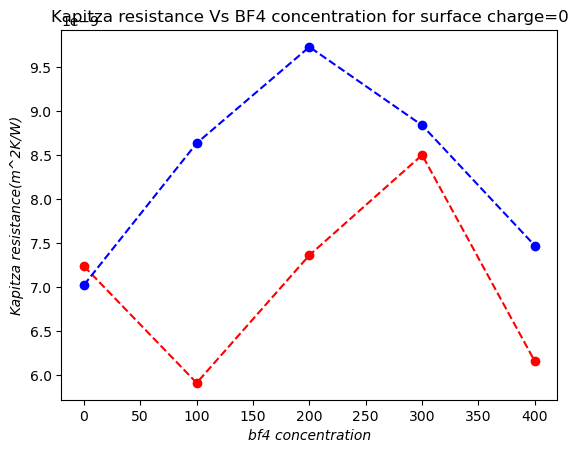

      0      1             2             3
1   0.1    0.0  7.187424e-09  4.122788e-09
8   0.1  100.0  6.760912e-09  4.797180e-09
15  0.1  200.0  7.703600e-09  5.070059e-09
22  0.1  300.0  5.968823e-09  3.452183e-09
29  0.1  400.0  6.225694e-09  3.945189e-09


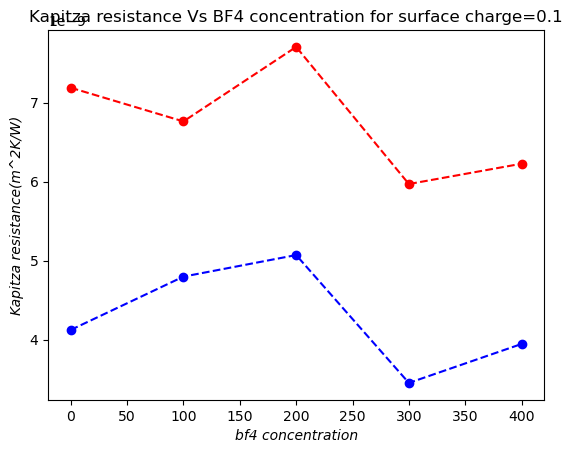

      0      1             2             3
2   0.2    0.0  1.194812e-09  2.639524e-09
9   0.2  100.0  3.153532e-09  1.559727e-09
16  0.2  200.0  3.449990e-09  2.626247e-09
23  0.2  300.0  4.407555e-09  3.160579e-09
30  0.2  400.0  3.441716e-09  2.132120e-09


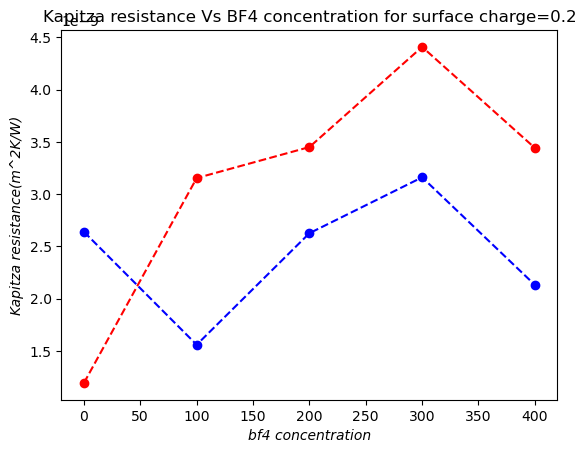

      0      1             2             3
3   0.3    0.0  1.276769e-08  7.836826e-09
10  0.3  100.0  5.347015e-09  7.461872e-09
17  0.3  200.0  5.317781e-09  5.880503e-09
24  0.3  300.0  6.959317e-09  6.840890e-09
31  0.3  400.0  5.595098e-09  4.923655e-09


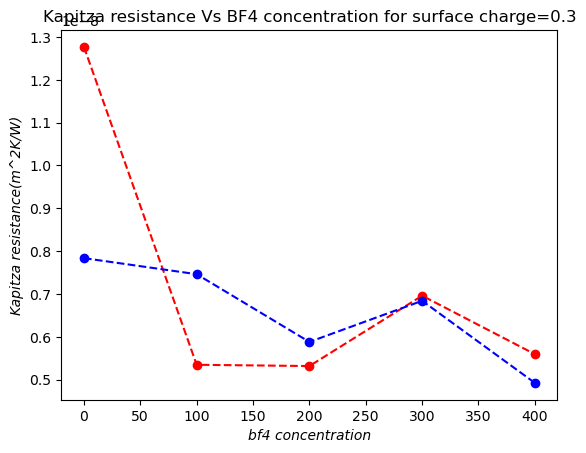

      0      1             2             3
4   0.4    0.0  1.474430e-08  6.003415e-09
11  0.4  100.0  1.105950e-08  9.359948e-09
18  0.4  200.0  7.940923e-09  9.060275e-09
25  0.4  300.0  9.365133e-09  1.116144e-08
32  0.4  400.0  1.091375e-08  1.096722e-08


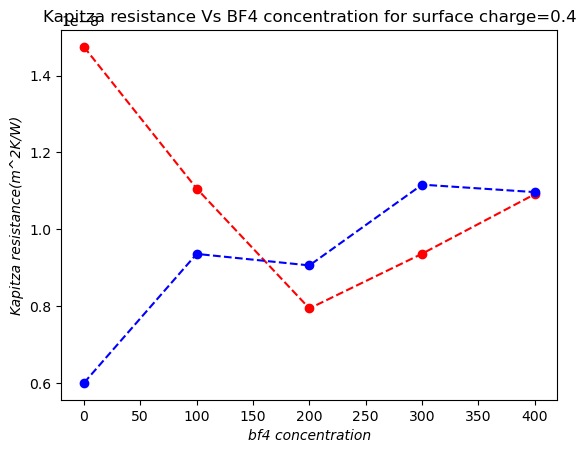

      0      1             2             3
5   0.5    0.0  1.474430e-08  6.003415e-09
12  0.5  100.0  1.613744e-08  9.052297e-09
19  0.5  200.0  1.428153e-08  1.116739e-08
26  0.5  300.0  1.222029e-08  1.060756e-08
33  0.5  400.0  1.488026e-08  1.101836e-08


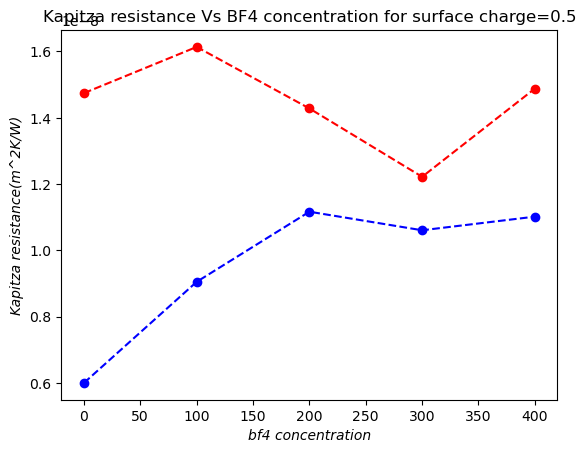

      0      1             2             3
6   0.6    0.0  1.233182e-08  7.249024e-09
13  0.6  100.0  1.317386e-08  9.214531e-09
20  0.6  200.0  1.173513e-08  9.764584e-09
27  0.6  300.0  1.284714e-08  5.505610e-09
34  0.6  400.0  1.677397e-08  1.226097e-08


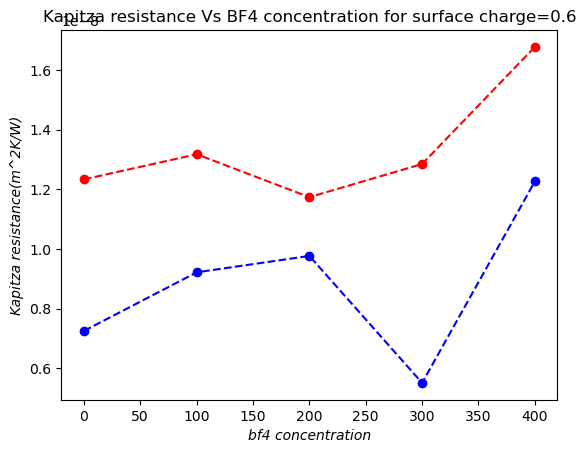

In [18]:
crange=[0,0.1,0.2,0.3,0.4,0.5,0.6]
for c in crange:
    data = pd.read_csv("K_vs_molarity.dat",sep='\s+',skiprows=[0],header=None)
    data = pd.DataFrame(data)
    #print(data)
    select_con = data.loc[data.iloc[:,0] == c]
    print(select_con)
    x = select_con[1]
    y1 = select_con[2]
    y2 = select_con[3]    
    plt.title('Kapitza resistance Vs BF4 concentration for surface charge='+str(c))
    plt.plot(x, y1,color="red", marker="o",  linestyle="--",label='kapitza_left')
    plt.plot(x, y2,color="blue", marker="o",  linestyle="--",label='kapitza_right')
    plt.xlabel('bf4 concentration', style='italic')
    plt.ylabel('Kapitza resistance(m^2K/W)', style='italic')
    plt.savefig("K_vs_mix_ratio"+'.charge='+str(c)+'.png')
    plt.show()

## 3. EDL Structure for different Surface Charge

In [10]:
import MDAnalysis
from MDAnalysis.analysis.density import density_from_Universe
from MDAnalysis.analysis.lineardensity import LinearDensity
import numpy as np
from itertools import count

class Smooth_Density(object):
    
    def __init__(self, **kwargs):
        for key,value in kwargs.items():
            setattr(self, key, value)
            
    def density(self, psf, dcd, segid, resname):
        u = MDAnalysis.Universe(psf, dcd)
        mol = u.select_atoms(segid)

        ldens = LinearDensity(mol, grouping ='atoms', binsize=0.5)
        ldens.run()
        D = ldens.results
        x = np.linspace(1,np.size(D['x']['pos']),np.size(D['x']['pos']))
        y = np.linspace(1,np.size(D['y']['pos']),np.size(D['y']['pos']))
        z = np.linspace(1,np.size(D['z']['pos']),np.size(D['z']['pos']))
        return x, D['x']['pos'], y, D['y']['pos'], z, D['z']['pos']

    def density_smooth(self):
        
        folder="T"+str(self.T)+"P"+str(self.P)+"_dT"+str(self.dT)+"_"+str(self.index)
        psf_wat = self.wat_input_files_path+folder+'/inputFiles/waterGnc.psf'
        dcd_wat = self.wat_input_files_path+folder+'/outputFiles/waterGnc.dcd'
        
        x, Dx, y, Dy, z, Dz = self.density(psf_wat, dcd_wat, self.wat_segid, self.wat_resname)
        
#         #Saving the density data
#         fname = self.wat_output_files_path+'water_Density_T'+str(T)+'.dat'
#         np.savetxt(fname, np.column_stack((z, Dz)))
        
        axis = self.axis

        if (axis == "x"):
            wat_X = x/self.conv_factor 
            wat_Den = Dx/self.wat_norm
        elif (axis == "y"):
            wat_X = y/self.conv_factor 
            wat_Den = Dy/self.wat_norm
        else:
            wat_X = z/self.conv_factor 
            wat_Den = Dz/self.wat_norm
        
    def read_denstiy(self, T):
        fname = self.wat_output_files_path+'water_Density_T'+str(T)+'.dat'
        wat_data = np.loadtxt(fname)
        wat_X = wat_data[:,0]/self.conv_factor 
        wat_Den = wat_data[:,1]/np.mean(wat_data[20:60,1])
        
        return wat_X, wat_Den

ImportError: cannot import name 'density_from_Universe' from 'MDAnalysis.analysis.density' (/home/arjun/.local/lib/python3.9/site-packages/MDAnalysis/analysis/density.py)

## 4. EDL Structure for different Mixture Ratio